In [ ]:
# 1: Imports and Setup

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import json
import uuid
import os
import random
import zipfile
from typing import Dict, List, Tuple, Optional
from tqdm.notebook import tqdm
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("All imports done")

All imports done


In [ ]:
# 2: Configuration Parameters

CONFIG = {
    "num_images": 3000,
    "output_dir": "synthetic_dataset",

    "num_lines_range": (1, 5),
    "points_per_line_range": (4, 12),

    "num_bars_range": (3, 8),
    "prob_bar_chart": 0.25,

    "fig_sizes": [(9, 6), (10, 7), (11, 7), (12, 8), (10, 8)],
    "dpi_range": (90, 120),

    "prob_grid": 0.40,
    "prob_legend": 0.95,
    "prob_title": 0.60,
    "prob_asymmetric_errors": 0.30,
    "prob_remove_spines": 0.20,
    "prob_annotations": 0.15,
    "prob_sample_size_labels": 0.10,
    "prob_no_error_bar": 0.15,

    "include_boundary_points": True,
}

print("Configuration loaded")
print(f"Target images: {CONFIG['num_images']}")
print(f"Bar chart probability: {CONFIG['prob_bar_chart']*100:.0f}%")
print(f"Include boundary points: {CONFIG['include_boundary_points']}")

Configuration loaded
Target images: 3000
Bar chart probability: 25%
Include boundary points: True


In [ ]:
# 3: Data Patterns (37 Patterns)

def generate_data_pattern(x: np.ndarray, y_range: Tuple[float, float], pattern: str) -> np.ndarray:
    """Generate Y values based on specified pattern."""
    y_min, y_max = y_range
    y_span = y_max - y_min
    n = len(x)

    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-10)

    if pattern == "increasing":
        slope = np.random.uniform(0.7, 1.0)
        y = x_norm * slope
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "decreasing":
        slope = np.random.uniform(0.7, 1.0)
        y = 1 - x_norm * slope
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "steep_increase":
        y = x_norm ** 0.5
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "steep_decrease":
        y = 1 - x_norm ** 0.5
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "plateau":
        transition = np.random.uniform(0.2, 0.4)
        y = np.zeros(n)
        for i, xi in enumerate(x_norm):
            if xi < transition:
                y[i] = xi / transition * 0.7
            else:
                y[i] = 0.7
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "plateau_high":
        y = np.ones(n) * np.random.uniform(0.75, 0.9)
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "plateau_low":
        y = np.ones(n) * np.random.uniform(0.1, 0.25)
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "delayed_plateau":
        delay = np.random.uniform(0.2, 0.4)
        transition_end = delay + np.random.uniform(0.2, 0.3)
        y = np.zeros(n)
        for i, xi in enumerate(x_norm):
            if xi < delay:
                y[i] = 0.2
            elif xi < transition_end:
                y[i] = 0.2 + (xi - delay) / (transition_end - delay) * 0.6
            else:
                y[i] = 0.8
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "sigmoid":
        steepness = np.random.uniform(8, 12)
        midpoint = np.random.uniform(0.4, 0.6)
        y = 1 / (1 + np.exp(-steepness * (x_norm - midpoint)))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "sigmoid_steep":
        steepness = np.random.uniform(15, 25)
        midpoint = np.random.uniform(0.4, 0.6)
        y = 1 / (1 + np.exp(-steepness * (x_norm - midpoint)))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "sigmoid_gradual":
        steepness = np.random.uniform(4, 6)
        midpoint = np.random.uniform(0.4, 0.6)
        y = 1 / (1 + np.exp(-steepness * (x_norm - midpoint)))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "inverse_sigmoid":
        steepness = np.random.uniform(8, 12)
        midpoint = np.random.uniform(0.4, 0.6)
        y = 1 - 1 / (1 + np.exp(-steepness * (x_norm - midpoint)))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "exponential_growth":
        rate = np.random.uniform(2, 4)
        y = (np.exp(rate * x_norm) - 1) / (np.exp(rate) - 1)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "exponential_decay":
        rate = np.random.uniform(2, 4)
        y = np.exp(-rate * x_norm)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "double_exponential":
        k_abs = np.random.uniform(3, 5)
        k_elim = np.random.uniform(1, 2)
        y = (np.exp(-k_elim * x_norm) - np.exp(-k_abs * x_norm))
        y = y / (y.max() + 1e-10)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "oscillating":
        frequency = np.random.uniform(1.5, 3)
        phase = np.random.uniform(0, 2 * np.pi)
        y = 0.5 + 0.35 * np.sin(2 * np.pi * frequency * x_norm + phase)
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "damped_oscillation":
        frequency = np.random.uniform(2, 4)
        decay = np.random.uniform(1, 3)
        y = 0.5 + 0.4 * np.exp(-decay * x_norm) * np.sin(2 * np.pi * frequency * x_norm)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "growing_oscillation":
        frequency = np.random.uniform(2, 3)
        y = 0.5 + 0.15 * (1 + x_norm) * np.sin(2 * np.pi * frequency * x_norm)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "multi_frequency":
        f1, f2 = np.random.uniform(1, 2), np.random.uniform(3, 5)
        y = 0.5 + 0.2 * np.sin(2 * np.pi * f1 * x_norm) + 0.15 * np.sin(2 * np.pi * f2 * x_norm)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "u_shape":
        vertex = np.random.uniform(0.4, 0.6)
        y = 4 * (x_norm - vertex) ** 2
        y = y / (y.max() + 1e-10) * 0.7 + 0.15
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "inverse_u":
        vertex = np.random.uniform(0.4, 0.6)
        y = 1 - 4 * (x_norm - vertex) ** 2
        y = np.clip(y, 0.1, 1)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "skewed_u":
        vertex = np.random.uniform(0.3, 0.5)
        left_steep = np.random.uniform(2, 4)
        right_steep = np.random.uniform(1, 2)
        y = np.where(x_norm < vertex,
                     left_steep * (x_norm - vertex) ** 2,
                     right_steep * (x_norm - vertex) ** 2)
        y = y / (y.max() + 1e-10) * 0.7 + 0.15
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "step_up":
        step_point = np.random.uniform(0.3, 0.7)
        y = np.where(x_norm < step_point, 0.2, 0.8)
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "step_down":
        step_point = np.random.uniform(0.3, 0.7)
        y = np.where(x_norm < step_point, 0.8, 0.2)
        noise = np.random.normal(0, 0.03, n)
        y = y + noise

    elif pattern == "multi_step":
        n_steps = np.random.randint(2, 4)
        step_points = np.sort(np.random.uniform(0.2, 0.8, n_steps))
        step_values = np.sort(np.random.uniform(0.2, 0.9, n_steps + 1))
        y = np.ones(n) * step_values[0]
        for i, sp in enumerate(step_points):
            y = np.where(x_norm >= sp, step_values[i + 1], y)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "single_peak":
        center = np.random.uniform(0.3, 0.7)
        width = np.random.uniform(0.1, 0.2)
        y = 0.2 + 0.7 * np.exp(-((x_norm - center) ** 2) / (2 * width ** 2))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "double_peak":
        c1, c2 = np.random.uniform(0.2, 0.4), np.random.uniform(0.6, 0.8)
        w1, w2 = np.random.uniform(0.08, 0.12), np.random.uniform(0.08, 0.12)
        y = 0.15 + 0.4 * np.exp(-((x_norm - c1) ** 2) / (2 * w1 ** 2))
        y += 0.5 * np.exp(-((x_norm - c2) ** 2) / (2 * w2 ** 2))
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "asymmetric_peak":
        center = np.random.uniform(0.3, 0.5)
        y = np.zeros(n)
        for i, xi in enumerate(x_norm):
            if xi < center:
                y[i] = 0.2 + 0.7 * np.exp(-((xi - center) ** 2) / 0.02)
            else:
                y[i] = 0.2 + 0.7 * np.exp(-((xi - center) ** 2) / 0.08)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "biphasic_increase":
        transition = np.random.uniform(0.3, 0.5)
        y = np.where(x_norm < transition,
                     x_norm / transition * 0.5,
                     0.5 + (x_norm - transition) / (1 - transition) * 0.4)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "biphasic_decrease":
        transition = np.random.uniform(0.3, 0.5)
        y = np.where(x_norm < transition,
                     1 - x_norm / transition * 0.5,
                     0.5 - (x_norm - transition) / (1 - transition) * 0.35)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "michaelis_menten":
        km = np.random.uniform(0.2, 0.5)
        vmax = np.random.uniform(0.8, 1.0)
        y = vmax * x_norm / (km + x_norm)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "hill_equation":
        k = np.random.uniform(0.4, 0.6)
        hill_coef = np.random.uniform(2, 4)
        y = x_norm ** hill_coef / (k ** hill_coef + x_norm ** hill_coef)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "substrate_inhibition":
        km = np.random.uniform(0.2, 0.3)
        ki = np.random.uniform(0.6, 0.8)
        y = x_norm / (km + x_norm + x_norm ** 2 / ki)
        y = y / (y.max() + 1e-10)
        noise = np.random.normal(0, 0.02, n)
        y = y + noise

    elif pattern == "random":
        mean = np.random.uniform(0.4, 0.6)
        y = mean + np.random.normal(0, 0.1, n)

    elif pattern == "random_walk":
        steps = np.random.normal(0, 0.05, n)
        y = 0.5 + np.cumsum(steps)
        y = (y - y.min()) / (y.max() - y.min() + 1e-10)

    elif pattern == "noisy_increasing":
        y = x_norm * 0.7 + 0.15
        noise = np.random.normal(0, 0.08, n)
        y = y + noise

    elif pattern == "noisy_decreasing":
        y = 0.85 - x_norm * 0.7
        noise = np.random.normal(0, 0.08, n)
        y = y + noise

    else:
        y = np.random.uniform(0.2, 0.8, n)

    y = np.clip(y, 0, 1)
    y = y * y_span + y_min

    return y


ALL_PATTERNS = [
    "increasing", "decreasing", "steep_increase", "steep_decrease",
    "plateau", "plateau_high", "plateau_low", "delayed_plateau",
    "sigmoid", "sigmoid_steep", "sigmoid_gradual", "inverse_sigmoid",
    "exponential_growth", "exponential_decay", "double_exponential",
    "oscillating", "damped_oscillation", "growing_oscillation", "multi_frequency",
    "u_shape", "inverse_u", "skewed_u",
    "step_up", "step_down", "multi_step",
    "single_peak", "double_peak", "asymmetric_peak",
    "biphasic_increase", "biphasic_decrease",
    "michaelis_menten", "hill_equation", "substrate_inhibition",
    "random", "random_walk", "noisy_increasing", "noisy_decreasing"
]

print(f"Defined {len(ALL_PATTERNS)} data patterns")

Defined 37 data patterns


In [ ]:
# 4: Font Randomization System

def get_available_fonts():
    """Get list of actually available font families."""
    available = set()
    for font in fm.fontManager.ttflist:
        available.add(font.name)
    return sorted(list(available))


class FontRandomizer:
    """Handles font randomization for plots."""

    def __init__(self):
        self.system_fonts = get_available_fonts()

        preferred_fonts = [
            'DejaVu Sans',
            'DejaVu Serif',
            'DejaVu Sans Mono',
            'Liberation Sans',
            'Liberation Serif',
            'Liberation Mono',
            'FreeSans',
            'FreeSerif',
            'FreeMono',
            'Nimbus Sans',
            'Nimbus Roman',
            'Nimbus Mono',
            'Arial',
            'Times New Roman',
            'Courier New',
            'Helvetica',
            'Verdana',
        ]

        self.available_fonts = []
        for font in preferred_fonts:
            if font in self.system_fonts:
                self.available_fonts.append(font)

        if not self.available_fonts:
            self.available_fonts = ['DejaVu Sans']

        print(f" FontRandomizer initialized")
        print(f" System fonts found: {len(self.system_fonts)}")
        print(f" Using {len(self.available_fonts)} preferred fonts")

    def get_random_font_config(self) -> Dict:
        """Generate random font configuration."""
        font_family = random.choice(self.available_fonts)

        return {
            'font_family': font_family,
            'title_size': random.randint(11, 16),
            'title_weight': random.choice(['normal', 'bold']),
            'title_style': 'italic' if random.random() < 0.1 else 'normal',
            'label_size': random.randint(10, 14),
            'label_weight': random.choice(['normal', 'bold']),
            'tick_size': random.randint(8, 12),
            'legend_size': random.randint(8, 12),
        }

    def apply_to_plot(self, ax, fig, config: Dict):
        """Apply font configuration to plot."""
        try:
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [config['font_family']] + ['DejaVu Sans']
        except Exception:
            pass

        if ax.get_title():
            ax.title.set_fontsize(config['title_size'])
            ax.title.set_fontweight(config['title_weight'])
            ax.title.set_fontstyle(config['title_style'])

        ax.xaxis.label.set_fontsize(config['label_size'])
        ax.yaxis.label.set_fontsize(config['label_size'])
        ax.xaxis.label.set_fontweight(config['label_weight'])
        ax.yaxis.label.set_fontweight(config['label_weight'])

        ax.tick_params(axis='both', labelsize=config['tick_size'])

        legend = ax.get_legend()
        if legend:
            for text in legend.get_texts():
                text.set_fontsize(config['legend_size'])


font_randomizer = FontRandomizer()

 FontRandomizer initialized
 System fonts found: 24
 Using 6 preferred fonts


In [ ]:
# 5: Visual Style Generator

class VisualStyleGenerator:
    """Generates diverse visual styles for plots."""

    def __init__(self):
        self.color_palettes = {
            'default': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                       '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],

            'nature': ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F',
                      '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85'],

            'science': ['#3B4992', '#EE0000', '#008B45', '#631879', '#008280',
                       '#BB0021', '#5F559B', '#A20056', '#808180', '#1B1919'],

            'nejm': ['#BC3C29', '#0072B5', '#E18727', '#20854E', '#7876B1',
                    '#6F99AD', '#FFDC91', '#EE4C97'],

            'lancet': ['#00468B', '#ED0000', '#42B540', '#0099B4', '#925E9F',
                      '#FDAF91', '#AD002A', '#ADB6B6'],

            'jama': ['#374E55', '#DF8F44', '#00A1D5', '#B24745', '#79AF97',
                    '#6A6599', '#80796B'],

            'colorblind': ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442',
                          '#56B4E9', '#E69F00', '#000000'],

            'pastel': ['#AEC7E8', '#FFBB78', '#98DF8A', '#FF9896', '#C5B0D5',
                      '#C49C94', '#F7B6D2', '#C7C7C7', '#DBDB8D', '#9EDAE5'],

            'bold': ['#FF0000', '#0000FF', '#00FF00', '#FF00FF', '#FFFF00',
                    '#00FFFF', '#FF8000', '#8000FF'],

            'grayscale': ['#000000', '#404040', '#808080', '#A0A0A0', '#C0C0C0'],
        }

        self.markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '8', 'P', 'X', 'd']
        self.line_styles = ['-', '--', '-.', ':']
        self.backgrounds = ['#FFFFFF', '#FAFAFA', '#F5F5F5', '#F8F8F8',
                           '#FFFAFA', '#F0FFF0', '#FFFFF0']

    def get_random_style(self, num_lines: int = 1) -> Dict:
        """Generate random visual style."""

        palette_name = random.choice(list(self.color_palettes.keys()))
        colors = self.color_palettes[palette_name].copy()
        random.shuffle(colors)

        while len(colors) < num_lines:
            colors.extend(self.color_palettes['default'])
        colors = colors[:num_lines]

        markers = random.sample(self.markers, min(num_lines, len(self.markers)))
        while len(markers) < num_lines:
            markers.append(random.choice(self.markers))

        line_styles = [random.choice(self.line_styles) for _ in range(num_lines)]

        return {
            'palette_name': palette_name,
            'colors': colors,
            'markers': markers,
            'line_styles': line_styles,
            'background': random.choice(self.backgrounds),
            'capsize': random.uniform(3, 8),
            'capthick': random.uniform(1.0, 2.5),
            'elinewidth': random.uniform(1.0, 2.5),
            'markersize': random.randint(5, 12),
            'linewidth': random.uniform(1.0, 2.5),
            'alpha': random.uniform(0.85, 1.0),
        }


style_generator = VisualStyleGenerator()
print("VisualStyleGenerator initialized!")
print(f"Color palettes: {len(style_generator.color_palettes)}")

VisualStyleGenerator initialized!
Color palettes: 10


In [ ]:
# 6: Scientific Topics Database

TOPICS = {
    "medical_hba1c": {
        "line_names": [
            "HbA1c_Placebo", "HbA1c_Treatment", "HbA1c_Exenatide_ER",
            "HbA1c_Metformin", "HbA1c_Insulin", "HbA1c_Combination",
            "HbA1c_Control", "HbA1c_Active", "HbA1c_Low_Dose", "HbA1c_High_Dose"
        ],
        "x_labels": ["Weeks", "Time (weeks)", "Study Week", "Months",
                     "Time on Study (Months)", "Follow-up (weeks)"],
        "y_labels": ["HbA1c (%)", "A1c (%)", "Glycated Hemoglobin (%)",
                     "HbA1c Change (%)", "Mean HbA1c (%)"],
        "titles": ["HbA1c Levels Over Time", "Glycemic Control", "A.", "B.",
                   "Figure A", "Primary Endpoint", ""],
        "y_range": (5.5, 10.5),
        "x_range": (0, 60),
        "patterns": ["decreasing", "plateau", "sigmoid_gradual", "biphasic_decrease",
                     "delayed_plateau", "noisy_decreasing", "random"],
        "supports_bar": True,
        "bar_categories": ["Baseline", "Week 4", "Week 8", "Week 12", "Week 24", "Week 52", "Endpoint"],
        "bar_groups": ["Placebo", "Treatment", "Low Dose", "High Dose"]
    },

    "medical_clinical": {
        "line_names": [
            "Placebo", "Treatment", "Control", "Drug_A", "Drug_B",
            "Low_Dose", "High_Dose", "Medium_Dose", "Baseline", "Experimental"
        ],
        "x_labels": ["Time (weeks)", "Days", "Months", "Visit Number",
                     "Treatment Week", "Study Day"],
        "y_labels": ["Blood Glucose (mg/dL)", "BMI (kg/m²)", "Body Weight (kg)",
                     "Systolic BP (mmHg)", "Heart Rate (bpm)", "Response Rate (%)"],
        "titles": ["Treatment Efficacy", "Clinical Trial Results",
                   "Patient Outcomes", "Primary Endpoint Analysis", ""],
        "y_range": (0, 200),
        "x_range": (0, 52),
        "patterns": ["increasing", "decreasing", "plateau", "sigmoid",
                     "biphasic_increase", "delayed_plateau", "noisy_increasing"],
        "supports_bar": True,
        "bar_categories": ["Control", "Treatment A", "Treatment B", "Treatment C", "Combination"],
        "bar_groups": ["Week 0", "Week 12", "Week 24", "Week 52"]
    },

    "medical_survival": {
        "line_names": [
            "Treatment_Arm", "Control_Arm", "Drug_A", "Drug_B",
            "High_Risk", "Low_Risk", "Standard_Therapy", "Experimental_Therapy"
        ],
        "x_labels": ["Time (months)", "Time (years)", "Follow-up Duration",
                     "Survival Time (months)"],
        "y_labels": ["Survival Probability", "Overall Survival (%)",
                     "Progression-Free Survival (%)", "Event-Free Survival (%)"],
        "titles": ["Kaplan-Meier Survival Curve", "Overall Survival Analysis",
                   "Progression-Free Survival", ""],
        "y_range": (0, 100),
        "x_range": (0, 60),
        "patterns": ["decreasing", "step_down", "biphasic_decrease", "exponential_decay"],
        "supports_bar": True,
        "bar_categories": ["1 Year", "2 Year", "3 Year", "5 Year"],
        "bar_groups": ["Treatment", "Control", "Combined"]
    },

    "biology_cellular": {
        "line_names": [
            "Wild_Type", "Mutant", "Control", "Knockout", "Knockdown",
            "Treated", "Untreated", "Transfected", "siRNA", "CRISPR"
        ],
        "x_labels": ["Time (hours)", "Time (min)", "Time (days)",
                     "Concentration (μM)", "Dose (nM)"],
        "y_labels": ["Cell Viability (%)", "Proliferation Rate", "Apoptosis (%)",
                     "Migration Distance (μm)", "Colony Count", "Confluence (%)"],
        "titles": ["Cell Viability Assay", "Proliferation Analysis",
                   "Cytotoxicity Study", "Growth Curve", ""],
        "y_range": (0, 120),
        "x_range": (0, 72),
        "patterns": ["sigmoid", "exponential_growth", "plateau", "decreasing",
                     "inverse_sigmoid", "double_exponential"],
        "supports_bar": True,
        "bar_categories": ["Control", "10 nM", "50 nM", "100 nM", "500 nM", "1 μM"],
        "bar_groups": ["Wild Type", "Mutant", "Knockout"]
    },

    "biology_molecular": {
        "line_names": [
            "Gene_A", "Gene_B", "Control", "Reference", "Target",
            "Sample_1", "Sample_2", "Induced", "Basal"
        ],
        "x_labels": ["Time (hours)", "Time Point", "Concentration (ng/μL)",
                     "Treatment Duration (h)"],
        "y_labels": ["Relative Expression", "Fold Change", "mRNA Level (AU)",
                     "Protein Level (AU)", "Normalized Expression"],
        "titles": ["Gene Expression Analysis", "qPCR Results",
                   "Expression Profile", "Time Course", ""],
        "y_range": (0, 15),
        "x_range": (0, 48),
        "patterns": ["increasing", "single_peak", "double_peak", "oscillating",
                     "damped_oscillation", "plateau", "sigmoid"],
        "supports_bar": True,
        "bar_categories": ["Gene A", "Gene B", "Gene C", "Gene D", "Gene E"],
        "bar_groups": ["Control", "Treated", "Induced"]
    },

    "biochemistry_enzyme": {
        "line_names": [
            "Wild_Type_Enzyme", "Mutant_Enzyme", "Control",
            "Plus_Inhibitor", "Minus_Inhibitor", "Substrate_A", "Substrate_B"
        ],
        "x_labels": ["Substrate Concentration (mM)", "[S] (mM)",
                     "Time (min)", "Inhibitor Concentration (μM)"],
        "y_labels": ["Reaction Velocity (μM/min)", "V₀ (μM/s)", "Activity (U/mg)",
                     "Specific Activity", "% Activity"],
        "titles": ["Michaelis-Menten Kinetics", "Enzyme Kinetics",
                   "Inhibition Study", ""],
        "y_range": (0, 100),
        "x_range": (0, 50),
        "patterns": ["michaelis_menten", "hill_equation", "substrate_inhibition",
                     "sigmoid", "plateau", "inverse_u"],
        "supports_bar": True,
        "bar_categories": ["WT", "K45A", "R67E", "D102N", "Triple Mutant"],
        "bar_groups": ["Vmax", "Km", "kcat"]
    },

    "chemistry_analytical": {
        "line_names": [
            "Standard", "Sample", "Blank", "Reference",
            "Calibration", "Unknown", "Spike", "Recovery"
        ],
        "x_labels": ["Concentration (mg/L)", "Wavelength (nm)",
                     "Retention Time (min)", "Wavenumber (cm⁻¹)"],
        "y_labels": ["Absorbance", "Peak Area", "Intensity (counts)",
                     "Transmittance (%)", "Response", "Signal (AU)"],
        "titles": ["Calibration Curve", "Spectroscopic Analysis",
                   "Standard Curve", "Method Validation", ""],
        "y_range": (0, 2.5),
        "x_range": (0, 100),
        "patterns": ["increasing", "steep_increase", "single_peak",
                     "double_peak", "sigmoid"],
        "supports_bar": True,
        "bar_categories": ["Sample A", "Sample B", "Sample C", "Standard", "Blank"],
        "bar_groups": ["Run 1", "Run 2", "Run 3"]
    },

    "chemistry_reaction": {
        "line_names": [
            "Catalyst_A", "Catalyst_B", "No_Catalyst", "Control",
            "Product", "Reactant", "Intermediate"
        ],
        "x_labels": ["Time (min)", "Time (s)", "Temperature (°C)",
                     "Catalyst Loading (%)", "Reaction Time (h)"],
        "y_labels": ["Yield (%)", "Conversion (%)", "Selectivity (%)",
                     "Concentration (M)", "TON"],
        "titles": ["Reaction Progress", "Kinetic Study",
                   "Catalyst Comparison", "Temperature Effect", ""],
        "y_range": (0, 100),
        "x_range": (0, 120),
        "patterns": ["sigmoid", "exponential_growth", "plateau",
                     "biphasic_increase", "double_exponential"],
        "supports_bar": True,
        "bar_categories": ["Catalyst A", "Catalyst B", "Catalyst C", "No Catalyst"],
        "bar_groups": ["Yield", "Selectivity", "TON"]
    },

    "physics_experimental": {
        "line_names": [
            "Experimental", "Theoretical", "Simulation",
            "Model_A", "Model_B", "Fitted", "Raw_Data"
        ],
        "x_labels": ["Time (s)", "Frequency (Hz)", "Voltage (V)",
                     "Temperature (K)", "Wavelength (nm)"],
        "y_labels": ["Amplitude (V)", "Intensity (AU)", "Counts",
                     "Resistance (Ω)", "Power (W)", "Transmission (%)"],
        "titles": ["Experimental Results", "Data vs Theory",
                   "Frequency Response", "Spectral Analysis", ""],
        "y_range": (0, 100),
        "x_range": (0, 1000),
        "patterns": ["oscillating", "damped_oscillation", "exponential_decay",
                     "single_peak", "multi_frequency", "random_walk"],
        "supports_bar": True,
        "bar_categories": ["Sample 1", "Sample 2", "Sample 3", "Reference"],
        "bar_groups": ["Measured", "Predicted", "Error"]
    },

    "physics_materials": {
        "line_names": [
            "Material_A", "Material_B", "Sample_1", "Sample_2",
            "Annealed", "As_Deposited", "Bulk", "Thin_Film"
        ],
        "x_labels": ["Temperature (K)", "Strain (%)", "Stress (MPa)",
                     "Frequency (Hz)", "Magnetic Field (Oe)"],
        "y_labels": ["Magnetization (emu/g)", "Resistivity (Ω·cm)",
                     "Thermal Conductivity (W/m·K)", "Young's Modulus (GPa)"],
        "titles": ["Material Properties", "Characterization Results",
                   "Temperature Dependence", "Magnetic Properties", ""],
        "y_range": (0, 500),
        "x_range": (0, 400),
        "patterns": ["increasing", "decreasing", "sigmoid", "u_shape",
                     "inverse_u", "step_up", "multi_step"],
        "supports_bar": True,
        "bar_categories": ["Material A", "Material B", "Material C", "Control"],
        "bar_groups": ["300K", "200K", "100K", "4K"]
    },

    "environmental": {
        "line_names": [
            "Site_A", "Site_B", "Upstream", "Downstream",
            "Urban", "Rural", "Industrial", "Reference"
        ],
        "x_labels": ["Time (days)", "Month", "Season", "Year",
                     "Distance (km)", "Depth (m)"],
        "y_labels": ["Concentration (ppm)", "pH", "Dissolved O₂ (mg/L)",
                     "BOD (mg/L)", "Turbidity (NTU)", "Temperature (°C)"],
        "titles": ["Water Quality Monitoring", "Environmental Assessment",
                   "Seasonal Variation", "Site Comparison", ""],
        "y_range": (0, 100),
        "x_range": (0, 365),
        "patterns": ["oscillating", "multi_frequency", "random_walk",
                     "increasing", "decreasing", "noisy_increasing"],
        "supports_bar": True,
        "bar_categories": ["Spring", "Summer", "Fall", "Winter"],
        "bar_groups": ["Site A", "Site B", "Site C", "Reference"]
    },

    "engineering": {
        "line_names": [
            "Design_A", "Design_B", "Prototype", "Production",
            "FEA_Result", "Experimental", "Specification"
        ],
        "x_labels": ["Load (N)", "Load (kN)", "Displacement (mm)",
                     "Strain (%)", "Cycles", "Time (s)"],
        "y_labels": ["Stress (MPa)", "Strain (%)", "Displacement (mm)",
                     "Force (N)", "Fatigue Life (cycles)", "Deflection (mm)"],
        "titles": ["Stress-Strain Curve", "Fatigue Analysis",
                   "Load-Displacement", "Performance Test", ""],
        "y_range": (0, 500),
        "x_range": (0, 100),
        "patterns": ["increasing", "sigmoid", "plateau", "u_shape",
                     "biphasic_increase", "step_up"],
        "supports_bar": True,
        "bar_categories": ["Design A", "Design B", "Design C", "Baseline"],
        "bar_groups": ["Strength", "Stiffness", "Weight"]
    },

    "pharmacology": {
        "line_names": [
            "Drug_Plasma", "Drug_Tissue", "Metabolite",
            "IV_Bolus", "Oral", "Subcutaneous"
        ],
        "x_labels": ["Time (hours)", "Time (min)", "Time Post-Dose (h)",
                     "Dose (mg/kg)"],
        "y_labels": ["Plasma Concentration (ng/mL)", "AUC", "Cmax",
                     "Bioavailability (%)", "Clearance (L/h)"],
        "titles": ["Pharmacokinetic Profile", "Drug Concentration vs Time",
                   "Absorption-Elimination Curve", ""],
        "y_range": (0, 100),
        "x_range": (0, 24),
        "patterns": ["double_exponential", "asymmetric_peak", "exponential_decay",
                     "biphasic_decrease", "sigmoid"],
        "supports_bar": True,
        "bar_categories": ["Drug A", "Drug B", "Drug C", "Placebo"],
        "bar_groups": ["Cmax", "AUC", "Tmax", "T1/2"]
    },
}

print(f"Loaded {len(TOPICS)} scientific topics")

Loaded 13 scientific topics


In [ ]:
# 7: Error Bar Generation Functions

def generate_error_values(y: np.ndarray, y_range: Tuple[float, float], asymmetric: bool = False, prob_no_error: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate realistic error bar values.
    Some points may have no error bars (zero values).
    """
    y_span = y_range[1] - y_range[0]
    n = len(y)

    error_scale = y_span * random.uniform(0.02, 0.15)

    error_style = random.choice(["constant", "proportional", "heteroscedastic"])

    if error_style == "constant":
        base_errors = np.ones(n) * error_scale

    elif error_style == "proportional":
        base_errors = np.abs(y - y_range[0]) * random.uniform(0.05, 0.15)
        base_errors = np.clip(base_errors, error_scale * 0.3, error_scale * 2)

    else:
        base_errors = error_scale * (0.5 + np.abs(np.random.normal(0, 0.5, n)))

    noise = np.abs(np.random.normal(0, error_scale * 0.2, n))
    base_errors = base_errors + noise

    if asymmetric:
        top_errors = base_errors * np.random.uniform(0.6, 1.4, n)
        bottom_errors = base_errors * np.random.uniform(0.6, 1.4, n)
    else:
        top_errors = base_errors.copy()
        bottom_errors = base_errors.copy()

    if prob_no_error > 0:
        for i in range(n):
            if random.random() < prob_no_error:
                top_errors[i] = 0
                bottom_errors[i] = 0

    top_errors = np.abs(top_errors)
    bottom_errors = np.abs(bottom_errors)

    return top_errors, bottom_errors


print("Error generation functions defined")
print("Supports asymmetric errors")
print("Some points can have no error bars")

Error generation functions defined
Supports asymmetric errors
Some points can have no error bars


In [ ]:
# 8: Coordinate Extraction Functions (With Boundary Points)

def extract_pixel_coordinates_simple(ax, fig, x: np.ndarray, y: np.ndarray, top_err: np.ndarray, bottom_err: np.ndarray) -> List[Dict]:
    """Extract pixel coordinates for all data points."""
    fig.canvas.draw()

    img_height = fig.get_figheight() * fig.dpi

    points = []

    for i in range(len(x)):
        pixel_xy = ax.transData.transform((x[i], y[i]))

        image_x = pixel_xy[0]
        image_y = img_height - pixel_xy[1]

        if top_err[i] > 0 or bottom_err[i] > 0:
            upper_xy = ax.transData.transform((x[i], y[i] + top_err[i]))
            lower_xy = ax.transData.transform((x[i], y[i] - bottom_err[i]))

            upper_y = img_height - upper_xy[1]
            lower_y = img_height - lower_xy[1]

            top_dist = abs(image_y - upper_y)
            bottom_dist = abs(lower_y - image_y)
        else:
            top_dist = 0
            bottom_dist = 0

        points.append({
            "x": round(image_x, 6),
            "y": round(image_y, 6),
            "label": "",
            "topBarPixelDistance": round(top_dist, 6),
            "bottomBarPixelDistance": round(bottom_dist, 6),
            "deviationPixelDistance": round((top_dist + bottom_dist) / 2, 6)
        })

    return points


def add_boundary_points(ax, fig, points: List[Dict]) -> List[Dict]:
    """Add axis boundary points (xmin, xmax, ymin, ymax) with zero error distances."""
    img_height = fig.get_figheight() * fig.dpi

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    boundaries = [
        (xlim[0], ylim[0], "xmin"),
        (xlim[1], ylim[0], "xmax"),
        (xlim[0], ylim[0], "ymin"),
        (xlim[0], ylim[1], "ymax"),
    ]

    for bx, by, label in boundaries:
        pixel_xy = ax.transData.transform((bx, by))
        points.append({
            "x": round(pixel_xy[0], 6),
            "y": round(img_height - pixel_xy[1], 6),
            "label": label,
            "topBarPixelDistance": 0,
            "bottomBarPixelDistance": 0,
            "deviationPixelDistance": 0
        })

    return points


print("Coordinate extraction functions defined")
print("Data points with/without error bars")
print("Boundary points (xmin, xmax, ymin, ymax)")

Coordinate extraction functions defined
Data points with/without error bars
Boundary points (xmin, xmax, ymin, ymax)


In [ ]:
# 9: Main Generator Class

class EnhancedSyntheticGenerator:
    """Enhanced synthetic dataset generator with bar chart support."""

    def __init__(self, config: Dict, topics: Dict, output_dir: str):
        self.config = config
        self.topics = topics
        self.output_dir = output_dir
        self.images_dir = os.path.join(output_dir, "images")
        self.labels_dir = os.path.join(output_dir, "labels")

        self.font_randomizer = font_randomizer
        self.style_generator = style_generator

        os.makedirs(self.images_dir, exist_ok=True)
        os.makedirs(self.labels_dir, exist_ok=True)

        self.stats = {
            "total_generated": 0,
            "topic_counts": {t: 0 for t in topics.keys()},
            "pattern_counts": {},
            "palette_counts": {},
            "font_counts": {},
            "points_with_errors": 0,
            "points_without_errors": 0,
            "line_plots": 0,
            "bar_plots": 0,
            "errors": []
        }

    def _generate_line_data(self, topic: Dict, num_points: int) -> Tuple:
        """Generate data for one line."""
        x_range = topic.get("x_range", (0, 100))
        y_range = topic.get("y_range", (0, 100))
        patterns = topic.get("patterns", ["random"])

        x = np.sort(np.random.uniform(x_range[0], x_range[1], num_points))

        min_spacing = (x_range[1] - x_range[0]) * 0.03
        for i in range(1, len(x)):
            if x[i] - x[i-1] < min_spacing:
                x[i] = x[i-1] + min_spacing

        x = np.clip(x, x_range[0], x_range[1])

        pattern = random.choice(patterns)
        y = generate_data_pattern(x, y_range, pattern)

        self.stats["pattern_counts"][pattern] = self.stats["pattern_counts"].get(pattern, 0) + 1

        asymmetric = random.random() < self.config.get("prob_asymmetric_errors", 0.3)
        prob_no_error = self.config.get("prob_no_error_bar", 0.0)

        top_err, bottom_err = generate_error_values(y, y_range, asymmetric, prob_no_error)

        for i in range(len(top_err)):
            if top_err[i] > 0 or bottom_err[i] > 0:
                self.stats["points_with_errors"] += 1
            else:
                self.stats["points_without_errors"] += 1

        return x, y, top_err, bottom_err, pattern

    def _generate_bar_data(self, topic: Dict, num_bars: int, num_groups: int) -> Tuple:
        """Generate data for bar chart with error bars."""
        y_range = topic.get("y_range", (0, 100))
        y_min, y_max = y_range
        y_span = y_max - y_min

        # Generate bar heights
        bar_heights = []
        top_errors = []
        bottom_errors = []

        for g in range(num_groups):
            group_heights = []
            group_top_err = []
            group_bottom_err = []

            # Generate heights with some pattern
            base_height = np.random.uniform(y_min + y_span * 0.2, y_max - y_span * 0.2)

            for b in range(num_bars):
                # Add variation
                variation = np.random.uniform(-y_span * 0.3, y_span * 0.3)
                height = np.clip(base_height + variation, y_min + y_span * 0.1, y_max - y_span * 0.1)
                group_heights.append(height)

                # Generate error bars
                prob_no_error = self.config.get("prob_no_error_bar", 0.0)

                if random.random() < prob_no_error:
                    group_top_err.append(0)
                    group_bottom_err.append(0)
                    self.stats["points_without_errors"] += 1
                else:
                    error_scale = y_span * random.uniform(0.03, 0.15)

                    if random.random() < self.config.get("prob_asymmetric_errors", 0.3):
                        top_e = error_scale * random.uniform(0.6, 1.4)
                        bottom_e = error_scale * random.uniform(0.6, 1.4)
                    else:
                        top_e = bottom_e = error_scale

                    group_top_err.append(top_e)
                    group_bottom_err.append(bottom_e)
                    self.stats["points_with_errors"] += 1

            bar_heights.append(group_heights)
            top_errors.append(group_top_err)
            bottom_errors.append(group_bottom_err)

        return bar_heights, top_errors, bottom_errors

    def _add_annotations(self, ax, x: np.ndarray, y: np.ndarray,
                         top_err: np.ndarray, y_range: Tuple):
        """Add optional annotations."""
        if random.random() < self.config.get("prob_annotations", 0.15):
            num_annotations = random.randint(1, min(2, len(x)))
            valid_indices = list(range(1, len(x) - 1)) if len(x) > 2 else list(range(len(x)))
            if not valid_indices:
                return

            indices = random.sample(valid_indices, min(num_annotations, len(valid_indices)))

            for idx in indices:
                marker = random.choice(['*', '**', '***', '†'])
                y_offset = max(top_err[idx], (y_range[1] - y_range[0]) * 0.03) + (y_range[1] - y_range[0]) * 0.02

                if y[idx] + y_offset < y_range[1] * 0.95:
                    ax.annotate(
                        marker,
                        (x[idx], y[idx] + y_offset),
                        fontsize=random.randint(10, 12),
                        ha='center',
                        va='bottom',
                        fontweight='bold'
                    )

    def _get_legend_position(self, all_line_data: List[Dict], y_range: Tuple) -> str:
        """Determine best legend position to avoid data overlap."""
        right_y_values = []
        for data in all_line_data:
            if len(data["y"]) > 0:
                right_y_values.append(data["y"][-1])

        if not right_y_values:
            return 'best'

        right_y_mean = np.mean(right_y_values)
        y_mid = (y_range[0] + y_range[1]) / 2

        if right_y_mean > y_mid:
            return random.choice(['lower right', 'lower left', 'center left'])
        else:
            return random.choice(['upper right', 'upper left', 'center left'])

    def generate_bar_plot(self, topic_name: Optional[str] = None) -> Optional[str]:
        """Generate a bar chart with error bars."""
        try:
            if topic_name is None:
                topic_name = random.choice(list(self.topics.keys()))
            topic = self.topics[topic_name]

            num_bars = random.randint(*self.config.get("num_bars_range", (3, 8)))
            num_groups = random.randint(1, min(4, len(topic.get("bar_groups", ["Group"]))))

            fig_size = random.choice(self.config.get("fig_sizes", [(10, 7)]))
            dpi = random.randint(*self.config.get("dpi_range", (90, 120)))

            visual_style = self.style_generator.get_random_style(num_groups)
            font_config = self.font_randomizer.get_random_font_config()

            palette = visual_style['palette_name']
            self.stats["palette_counts"][palette] = self.stats["palette_counts"].get(palette, 0) + 1
            font = font_config['font_family']
            self.stats["font_counts"][font] = self.stats["font_counts"].get(font, 0) + 1

            fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
            fig.patch.set_facecolor(visual_style['background'])
            ax.set_facecolor(visual_style['background'])

            # Get categories and groups
            bar_categories = topic.get("bar_categories", [f"Cat {i+1}" for i in range(num_bars)])
            bar_groups = topic.get("bar_groups", [f"Group {i+1}" for i in range(num_groups)])

            # Make sure categories match num_bars EXACTLY
            if len(bar_categories) >= num_bars:
                bar_categories = random.sample(bar_categories, num_bars)

            else:
                # Not enough categories, generate more
                while len(bar_categories) < num_bars:
                    bar_categories.append(f"Cat_{len(bar_categories)+1}")
                bar_categories = bar_categories[:num_bars]

            # Make sure groups match num_groups EXACTLY
            if len(bar_groups) >= num_groups:
                bar_groups = random.sample(bar_groups, num_groups)
            else:
                while len(bar_groups) < num_groups:
                    bar_groups.append(f"Group_{len(bar_groups)+1}")
                bar_groups = bar_groups[:num_groups]


            # Generate bar data
            bar_heights, top_errors, bottom_errors = self._generate_bar_data(topic, num_bars, num_groups)

            # Bar positioning
            x = np.arange(num_bars)
            width = 0.8 / num_groups

            all_bar_data = []

            for g_idx in range(num_groups):
                offset = (g_idx - num_groups / 2 + 0.5) * width
                x_positions = x + offset

                bars = ax.bar(
                    x_positions,
                    bar_heights[g_idx],
                    width * 0.9,
                    yerr=[bottom_errors[g_idx], top_errors[g_idx]],
                    label=bar_groups[g_idx],
                    color=visual_style["colors"][g_idx],
                    edgecolor='black',
                    linewidth=0.5,
                    capsize=visual_style["capsize"],
                    error_kw={
                        'elinewidth': visual_style["elinewidth"],
                        'capthick': visual_style["capthick"],
                        'ecolor': 'black'
                    },
                    alpha=visual_style["alpha"]
                )

                # Store bar data
                all_bar_data.append({
                    "x_positions": x_positions,
                    "heights": bar_heights[g_idx],
                    "top_err": top_errors[g_idx],
                    "bottom_err": bottom_errors[g_idx],
                    "group_name": bar_groups[g_idx],
                    "width": width * 0.9
                })

            # Set x-axis
            ax.set_xticks(x)
            ax.set_xticklabels(bar_categories, rotation=random.choice([0, 15, 30, 45]))

            # Labels
            ax.set_xlabel(random.choice(["Category", "Group", "Condition", "Treatment"]), labelpad=10)
            ax.set_ylabel(random.choice(topic["y_labels"]), labelpad=10)

            # Title
            if random.random() < self.config.get("prob_title", 0.6):
                title = random.choice(topic["titles"])
                if title:
                    ax.set_title(title, pad=15)

            # Grid
            if random.random() < self.config.get("prob_grid", 0.4):
                ax.yaxis.grid(True, alpha=random.uniform(0.2, 0.4),
                             linestyle=random.choice(['-', '--', ':']), zorder=0)

            # Legend
            if num_groups > 1 and random.random() < self.config.get("prob_legend", 0.95):
                ax.legend(
                    loc=random.choice(['upper right', 'upper left', 'best']),
                    fontsize=font_config['legend_size'],
                    framealpha=0.9,
                    edgecolor='gray',
                    fancybox=True
                )

            # Spines
            if random.random() < self.config.get("prob_remove_spines", 0.20):
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

            self.font_randomizer.apply_to_plot(ax, fig, font_config)

            ax.tick_params(
                direction=random.choice(['in', 'out', 'inout']),
                pad=5,
                labelsize=font_config['tick_size']
            )

            # Set y-axis limits
            all_heights = [h for group in bar_heights for h in group]
            all_top_err = [e for group in top_errors for e in group]
            all_bottom_err = [e for group in bottom_errors for e in group]

            y_max_data = max([h + t for h, t in zip(all_heights, all_top_err)])
            y_min_data = min([h - b for h, b in zip(all_heights, all_bottom_err)])

            y_padding = (y_max_data - y_min_data) * 0.1
            ax.set_ylim(max(0, y_min_data - y_padding), y_max_data + y_padding)

            fig.tight_layout(pad=1.5)
            fig.canvas.draw()

            # Extract coordinates
            img_height = fig.get_figheight() * dpi
            all_labels = []

            for bar_data in all_bar_data:
                points = []

                for i in range(len(bar_data["x_positions"])):
                    x_pos = bar_data["x_positions"][i]
                    y_pos = bar_data["heights"][i]
                    top_e = bar_data["top_err"][i]
                    bottom_e = bar_data["bottom_err"][i]

                    # Transform to pixel coordinates (top of bar)
                    pixel_xy = ax.transData.transform((x_pos, y_pos))
                    image_x = pixel_xy[0]
                    image_y = img_height - pixel_xy[1]

                    # Calculate error bar pixel distances
                    if top_e > 0 or bottom_e > 0:
                        upper_xy = ax.transData.transform((x_pos, y_pos + top_e))
                        lower_xy = ax.transData.transform((x_pos, y_pos - bottom_e))

                        upper_y = img_height - upper_xy[1]
                        lower_y = img_height - lower_xy[1]

                        top_dist = abs(image_y - upper_y)
                        bottom_dist = abs(lower_y - image_y)
                    else:
                        top_dist = 0
                        bottom_dist = 0

                    points.append({
                        "x": round(image_x, 6),
                        "y": round(image_y, 6),
                        "label": "",
                        "topBarPixelDistance": round(top_dist, 6),
                        "bottomBarPixelDistance": round(bottom_dist, 6),
                        "deviationPixelDistance": round((top_dist + bottom_dist) / 2, 6)
                    })

                # Add boundary points
                if self.config.get("include_boundary_points", True):
                    points = add_boundary_points(ax, fig, points)

                all_labels.append({
                    "label": {"lineName": bar_data["group_name"]},
                    "points": points
                })

            file_id = str(uuid.uuid4())

            image_path = os.path.join(self.images_dir, f"{file_id}.png")
            plt.savefig(
                image_path,
                dpi=dpi,
                facecolor=fig.get_facecolor(),
                edgecolor='none'
            )
            plt.close(fig)

            label_path = os.path.join(self.labels_dir, f"{file_id}.json")
            with open(label_path, 'w') as f:
                json.dump(all_labels, f, indent=2)

            self.stats["total_generated"] += 1
            self.stats["topic_counts"][topic_name] += 1
            self.stats["bar_plots"] += 1

            return file_id

        except Exception as e:
            self.stats["errors"].append(f"Bar chart: {str(e)}")
            plt.close('all')
            return None

    def generate_single_plot(self, topic_name: Optional[str] = None) -> Optional[str]:
        """Generate a single plot (line or bar) with labels."""
        try:
            if topic_name is None:
                topic_name = random.choice(list(self.topics.keys()))
            topic = self.topics[topic_name]

            # Decide whether to generate bar chart or line plot
            if random.random() < self.config.get("prob_bar_chart", 0.25):
                return self.generate_bar_plot(topic_name)

            # Line plot generation (original code)
            self.stats["line_plots"] += 1

            num_lines = random.randint(*self.config.get("num_lines_range", (1, 5)))
            num_lines = min(num_lines, len(topic["line_names"]))
            points_per_line = random.randint(*self.config.get("points_per_line_range", (4, 12)))

            fig_size = random.choice(self.config.get("fig_sizes", [(10, 7)]))
            dpi = random.randint(*self.config.get("dpi_range", (90, 120)))

            visual_style = self.style_generator.get_random_style(num_lines)
            font_config = self.font_randomizer.get_random_font_config()

            palette = visual_style['palette_name']
            self.stats["palette_counts"][palette] = self.stats["palette_counts"].get(palette, 0) + 1
            font = font_config['font_family']
            self.stats["font_counts"][font] = self.stats["font_counts"].get(font, 0) + 1

            fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
            fig.patch.set_facecolor(visual_style['background'])
            ax.set_facecolor(visual_style['background'])

            selected_names = random.sample(topic["line_names"], num_lines)

            all_line_data = []
            all_labels = []

            for line_idx in range(num_lines):
                x, y, top_err, bottom_err, pattern = self._generate_line_data(topic, points_per_line)

                line_name = selected_names[line_idx]
                display_name = line_name.replace("_", " ")

                all_line_data.append({
                    "x": x, "y": y,
                    "top_err": top_err, "bottom_err": bottom_err,
                    "line_name": line_name
                })

                ax.errorbar(
                    x, y,
                    yerr=[bottom_err, top_err],
                    fmt=f'{visual_style["markers"][line_idx]}{visual_style["line_styles"][line_idx]}',
                    color=visual_style["colors"][line_idx],
                    ecolor=visual_style["colors"][line_idx],
                    capsize=visual_style["capsize"],
                    capthick=visual_style["capthick"],
                    elinewidth=visual_style["elinewidth"],
                    markersize=visual_style["markersize"],
                    linewidth=visual_style["linewidth"],
                    label=display_name,
                    alpha=visual_style["alpha"]
                )

                if line_idx == 0:
                    self._add_annotations(ax, x, y, top_err, topic["y_range"])

            ax.set_xlabel(random.choice(topic["x_labels"]), labelpad=10)
            ax.set_ylabel(random.choice(topic["y_labels"]), labelpad=10)

            if random.random() < self.config.get("prob_title", 0.6):
                title = random.choice(topic["titles"])
                if title:
                    ax.set_title(title, pad=15)

            if random.random() < self.config.get("prob_grid", 0.4):
                ax.grid(True, alpha=random.uniform(0.2, 0.4),
                       linestyle=random.choice(['-', '--', ':']), zorder=0)

            if random.random() < self.config.get("prob_legend", 0.95):
                legend_pos = self._get_legend_position(all_line_data, topic["y_range"])
                ax.legend(
                    loc=legend_pos,
                    fontsize=font_config['legend_size'],
                    framealpha=0.9,
                    edgecolor='gray',
                    fancybox=True
                )

            if random.random() < self.config.get("prob_remove_spines", 0.20):
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

            self.font_randomizer.apply_to_plot(ax, fig, font_config)

            ax.tick_params(
                direction=random.choice(['in', 'out', 'inout']),
                pad=5,
                labelsize=font_config['tick_size']
            )

            x_all = np.concatenate([d["x"] for d in all_line_data])
            y_all = np.concatenate([d["y"] for d in all_line_data])
            top_err_all = np.concatenate([d["top_err"] for d in all_line_data])
            bottom_err_all = np.concatenate([d["bottom_err"] for d in all_line_data])

            x_min, x_max = x_all.min(), x_all.max()
            y_with_top = y_all + top_err_all
            y_with_bottom = y_all - bottom_err_all
            y_min_data = y_with_bottom.min()
            y_max_data = y_with_top.max()

            x_padding = (x_max - x_min) * 0.05
            y_padding = (y_max_data - y_min_data) * 0.08

            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min_data - y_padding, y_max_data + y_padding)

            fig.tight_layout(pad=1.5)
            fig.canvas.draw()

            for data in all_line_data:
                points = extract_pixel_coordinates_simple(
                    ax, fig,
                    data["x"], data["y"],
                    data["top_err"], data["bottom_err"]
                )

                if self.config.get("include_boundary_points", True):
                    points = add_boundary_points(ax, fig, points)

                all_labels.append({
                    "label": {"lineName": data["line_name"]},
                    "points": points
                })

            file_id = str(uuid.uuid4())

            image_path = os.path.join(self.images_dir, f"{file_id}.png")
            plt.savefig(
                image_path,
                dpi=dpi,
                facecolor=fig.get_facecolor(),
                edgecolor='none'
            )
            plt.close(fig)

            label_path = os.path.join(self.labels_dir, f"{file_id}.json")
            with open(label_path, 'w') as f:
                json.dump(all_labels, f, indent=2)

            self.stats["total_generated"] += 1
            self.stats["topic_counts"][topic_name] += 1

            return file_id

        except Exception as e:
            self.stats["errors"].append(str(e))
            plt.close('all')
            return None

    def generate_dataset(self, num_images: int, balanced: bool = True):
        """Generate full dataset with proper balanced distribution."""
        print(f"Generating {num_images} synthetic plots...")
        print(f"Output: {self.output_dir}")
        print(f"Topics: {len(self.topics)}")
        print(f"Patterns: {len(ALL_PATTERNS)}")
        print(f"Bar chart probability: {self.config.get('prob_bar_chart', 0.25)*100:.0f}%")
        print(f"Include boundary points: {self.config.get('include_boundary_points', True)}")
        print()

        if balanced:
            topics_list = list(self.topics.keys())
            random.shuffle(topics_list)

            images_per_topic = num_images // len(topics_list)
            remainder = num_images % len(topics_list)

            topic_distribution = {}
            for i, topic_name in enumerate(topics_list):
                count = images_per_topic + (1 if i < remainder else 0)
                topic_distribution[topic_name] = count

            print("Topic distribution plan:")
            for topic, count in sorted(topic_distribution.items()):
                print(f"   {topic:25s}: {count:4d} images")
            print()

            with tqdm(total=num_images, desc="Generating") as pbar:
                for topic_name in topics_list:
                    count = topic_distribution[topic_name]

                    for _ in range(count):
                        self.generate_single_plot(topic_name)
                        pbar.update(1)
        else:
            with tqdm(total=num_images, desc="Generating") as pbar:
                for _ in range(num_images):
                    self.generate_single_plot()
                    pbar.update(1)

        self._print_summary()

    def _print_summary(self):
        """Print generation summary."""
        print()
        print("=" * 60)
        print("GENERATION SUMMARY")
        print("=" * 60)
        print(f"Total generated: {self.stats['total_generated']}")
        print(f"   Line plots: {self.stats['line_plots']}")
        print(f"   Bar charts: {self.stats['bar_plots']}")
        print(f"Errors: {len(self.stats['errors'])}")
        print()

        total_points = self.stats["points_with_errors"] + self.stats["points_without_errors"]
        if total_points > 0:
            pct_with = self.stats["points_with_errors"] / total_points * 100
            pct_without = self.stats["points_without_errors"] / total_points * 100
            print(f"Error bar statistics:")
            print(f"Points WITH error bars:    {self.stats['points_with_errors']:6d} ({pct_with:.1f}%)")
            print(f"Points WITHOUT error bars: {self.stats['points_without_errors']:6d} ({pct_without:.1f}%)")
            print()

        counts = list(self.stats["topic_counts"].values())
        min_count = min(counts)
        max_count = max(counts)
        mean_count = np.mean(counts)

        print(f"Topic distribution (min={min_count}, max={max_count}, mean={mean_count:.1f}):")
        for topic, count in sorted(self.stats["topic_counts"].items(), key=lambda x: -x[1]):
            pct = count / self.stats["total_generated"] * 100
            bar = "█" * int(pct * 2)
            print(f"   {topic:25s}: {count:4d} ({pct:5.2f}%) {bar}")
        print()

        print("Top 5 color palettes:")
        for palette, count in sorted(self.stats["palette_counts"].items(), key=lambda x: -x[1])[:5]:
            print(f"   {palette:15s}: {count:4d}")
        print()

        print("Top 10 patterns:")
        for pattern, count in sorted(self.stats["pattern_counts"].items(), key=lambda x: -x[1])[:10]:
            print(f"   {pattern:25s}: {count:4d}")

        if self.stats["errors"]:
            print()
            print(f"Errors ({len(self.stats['errors'])}):")
            for err in self.stats["errors"][:5]:
                print(f"   • {err[:70]}")


    def get_stats(self) -> Dict:
        """Return generation statistics."""
        return self.stats


print("EnhancedSyntheticGenerator class defined")
print("Line plots with error bars")
print("Bar charts with error bars")
print("Boundary points included")
print("Some points can have no error bars")

EnhancedSyntheticGenerator class defined
Line plots with error bars
Bar charts with error bars
Boundary points included
Some points can have no error bars


In [ ]:
# 10: ZIP Archive Creation

def create_zip_archive(source_dir: str, output_filename: str = "synthetic_dataset.zip") -> str:
    """Create a ZIP archive of the generated dataset."""
    print(f"Creating ZIP archive: {output_filename}")

    images_dir = os.path.join(source_dir, "images")
    labels_dir = os.path.join(source_dir, "labels")

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.json')]

    print(f"Images: {len(image_files)}")
    print(f"Labels: {len(label_files)}")

    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        print("   Adding images...")
        for filename in tqdm(image_files, desc="   Zipping images"):
            file_path = os.path.join(images_dir, filename)
            arcname = os.path.join("dataset", "images", filename)
            zipf.write(file_path, arcname)

        print("   Adding labels...")
        for filename in tqdm(label_files, desc="   Zipping labels"):
            file_path = os.path.join(labels_dir, filename)
            arcname = os.path.join("dataset", "labels", filename)
            zipf.write(file_path, arcname)

    file_size_mb = os.path.getsize(output_filename) / (1024 * 1024)
    file_size_gb = file_size_mb / 1024

    print()
    print(f"ZIP archive created successfully!")
    print(f"Filename: {output_filename}")
    if file_size_gb >= 1:
        print(f"Size: {file_size_gb:.2f} GB")
    else:
        print(f"Size: {file_size_mb:.2f} MB")

    return output_filename


print("ZIP creation function defined")

ZIP creation function defined


In [ ]:
# 11: Run Dataset Generation

generator = EnhancedSyntheticGenerator(
    config=CONFIG,
    topics=TOPICS,
    output_dir=CONFIG["output_dir"]
)

NUM_IMAGES = 3000

generator.generate_dataset(
    num_images=NUM_IMAGES,
    balanced=True
)

generation_stats = generator.get_stats()

Generating 3000 synthetic plots...
Output: synthetic_dataset
Topics: 13
Patterns: 37
Bar chart probability: 25%
Include boundary points: True

Topic distribution plan:
   biochemistry_enzyme      :  231 images
   biology_cellular         :  231 images
   biology_molecular        :  231 images
   chemistry_analytical     :  231 images
   chemistry_reaction       :  231 images
   engineering              :  231 images
   environmental            :  230 images
   medical_clinical         :  230 images
   medical_hba1c            :  230 images
   medical_survival         :  231 images
   pharmacology             :  231 images
   physics_experimental     :  231 images
   physics_materials        :  231 images



Generating:   0%|          | 0/3000 [00:00<?, ?it/s]


GENERATION SUMMARY
Total generated: 3000
   Line plots: 2243
   Bar charts: 757
Errors: 0

Error bar statistics:
Points WITH error bars:     53151 (84.9%)
Points WITHOUT error bars:   9469 (15.1%)

Topic distribution (min=230, max=231, mean=230.8):
   medical_survival         :  231 ( 7.70%) ███████████████
   biology_cellular         :  231 ( 7.70%) ███████████████
   biology_molecular        :  231 ( 7.70%) ███████████████
   biochemistry_enzyme      :  231 ( 7.70%) ███████████████
   chemistry_analytical     :  231 ( 7.70%) ███████████████
   chemistry_reaction       :  231 ( 7.70%) ███████████████
   physics_experimental     :  231 ( 7.70%) ███████████████
   physics_materials        :  231 ( 7.70%) ███████████████
   engineering              :  231 ( 7.70%) ███████████████
   pharmacology             :  231 ( 7.70%) ███████████████
   medical_hba1c            :  230 ( 7.67%) ███████████████
   medical_clinical         :  230 ( 7.67%) ███████████████
   environmental            : 

In [ ]:
# 12: Validation Function

def validate_dataset(images_dir: str, labels_dir: str, sample_size: int = 100) -> Dict:
    """Validate generated dataset."""

    results = {
        "total_images": 0,
        "total_labels": 0,
        "matched_pairs": 0,
        "coordinate_checks": {"passed": 0, "failed": 0},
        "data_points": 0,
        "boundary_points": 0,
        "points_with_errors": 0,
        "points_without_errors": 0
    }

    # Count files
    image_files = set(f.replace('.png', '') for f in os.listdir(images_dir) if f.endswith('.png'))
    label_files = set(f.replace('.json', '') for f in os.listdir(labels_dir) if f.endswith('.json'))

    results["total_images"] = len(image_files)
    results["total_labels"] = len(label_files)
    results["matched_pairs"] = len(image_files & label_files)

    # Sample files for validation
    matched_files = list(image_files & label_files)
    sample_files = random.sample(matched_files, min(sample_size, len(matched_files)))

    for file_id in sample_files:
        # Load image dimensions
        img_path = os.path.join(images_dir, f"{file_id}.png")
        img = Image.open(img_path)
        img_w, img_h = img.size

        # Load JSON
        label_path = os.path.join(labels_dir, f"{file_id}.json")
        with open(label_path, 'r') as f:
            labels = json.load(f)

        for line in labels:
            for point in line["points"]:
                x, y = point["x"], point["y"]

                # Check bounds
                if 0 <= x <= img_w + 10 and 0 <= y <= img_h + 10:
                    results["coordinate_checks"]["passed"] += 1
                else:
                    results["coordinate_checks"]["failed"] += 1

                # Count point types
                if point["label"] == "":
                    results["data_points"] += 1
                    if point["topBarPixelDistance"] > 0:
                        results["points_with_errors"] += 1
                    else:
                        results["points_without_errors"] += 1
                else:
                    results["boundary_points"] += 1

    # Print results
    print("=" * 60)
    print("VALIDATION RESULTS")
    print("=" * 60)
    print(f"Total images: {results['total_images']}")
    print(f"Total labels: {results['total_labels']}")
    print(f"Matched pairs: {results['matched_pairs']}")
    print()
    print(f"Coordinate checks (sampled {len(sample_files)} files):")
    print(f"   Passed: {results['coordinate_checks']['passed']}")
    print(f"   Failed: {results['coordinate_checks']['failed']}")
    print()
    print(f"Point types:")
    print(f"   Data points: {results['data_points']}")
    print(f"   Boundary points: {results['boundary_points']}")
    print(f"   With error bars: {results['points_with_errors']}")
    print(f"   Without error bars: {results['points_without_errors']}")

    return results


print("Validation function defined")

Validation function defined


In [ ]:
# 13: Validate Dataset

validation_results = validate_dataset(
    images_dir=os.path.join(CONFIG["output_dir"], "images"),
    labels_dir=os.path.join(CONFIG["output_dir"], "labels"),
    sample_size=min(100, CONFIG["num_images"])
)

VALIDATION RESULTS
Total images: 3000
Total labels: 3000
Matched pairs: 3000

Coordinate checks (sampled 100 files):
   Passed: 3197
   Failed: 0

Point types:
   Data points: 2073
   Boundary points: 1124
   With error bars: 1777
   Without error bars: 296


In [ ]:
# 14: Visualization Function

def visualize_with_overlay(images_dir: str, labels_dir: str, num_samples: int = 6):
    """Visualize sample images with RED coordinate overlay and labels."""

    image_files = [f.replace('.png', '') for f in os.listdir(images_dir) if f.endswith('.png')]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    cols = 2
    rows = (num_samples + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    axes = axes.flatten() if num_samples > 1 else [axes]

    for ax, file_id in zip(axes, sample_files):
        # Load image
        img_path = os.path.join(images_dir, f"{file_id}.png")
        img = Image.open(img_path)
        ax.imshow(img)

        # Load JSON
        label_path = os.path.join(labels_dir, f"{file_id}.json")
        with open(label_path, 'r') as f:
            labels = json.load(f)

        # Draw ALL points in RED
        for line in labels:
            for point in line["points"]:
                x, y = point["x"], point["y"]
                top_dist = point["topBarPixelDistance"]
                bottom_dist = point["bottomBarPixelDistance"]
                label = point["label"]

                # Red X marker
                ax.scatter(x, y, c='red', s=120, marker='x', linewidths=2, zorder=10)

                # Red error bar lines
                if top_dist > 0 or bottom_dist > 0:
                    ax.plot([x, x], [y - top_dist, y + bottom_dist], c='red', linewidth=1.5, zorder=5)
                    ax.plot([x - 5, x + 5], [y - top_dist, y - top_dist], c='red', linewidth=1.5, zorder=5)
                    ax.plot([x - 5, x + 5], [y + bottom_dist, y + bottom_dist], c='red', linewidth=1.5, zorder=5)

                # Add label text (xmin, xmax, ymin, ymax)
                if label != "":
                    ax.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points',
                               fontsize=9, color='red', fontweight='bold',
                               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

        ax.set_title(f"{file_id[:25]}...", fontsize=9)
        ax.axis('off')

    for idx in range(len(sample_files), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig("overlay_verification.png", dpi=120, bbox_inches='tight')
    plt.close()


print("Visualization function defined")

Visualization function defined


Manual Coordinate Verification (Chart and JSON Matches or not)
Red X = JSON coordinates | Red lines = Error bars
Labels: xmin, xmax, ymin, ymax = Boundary points



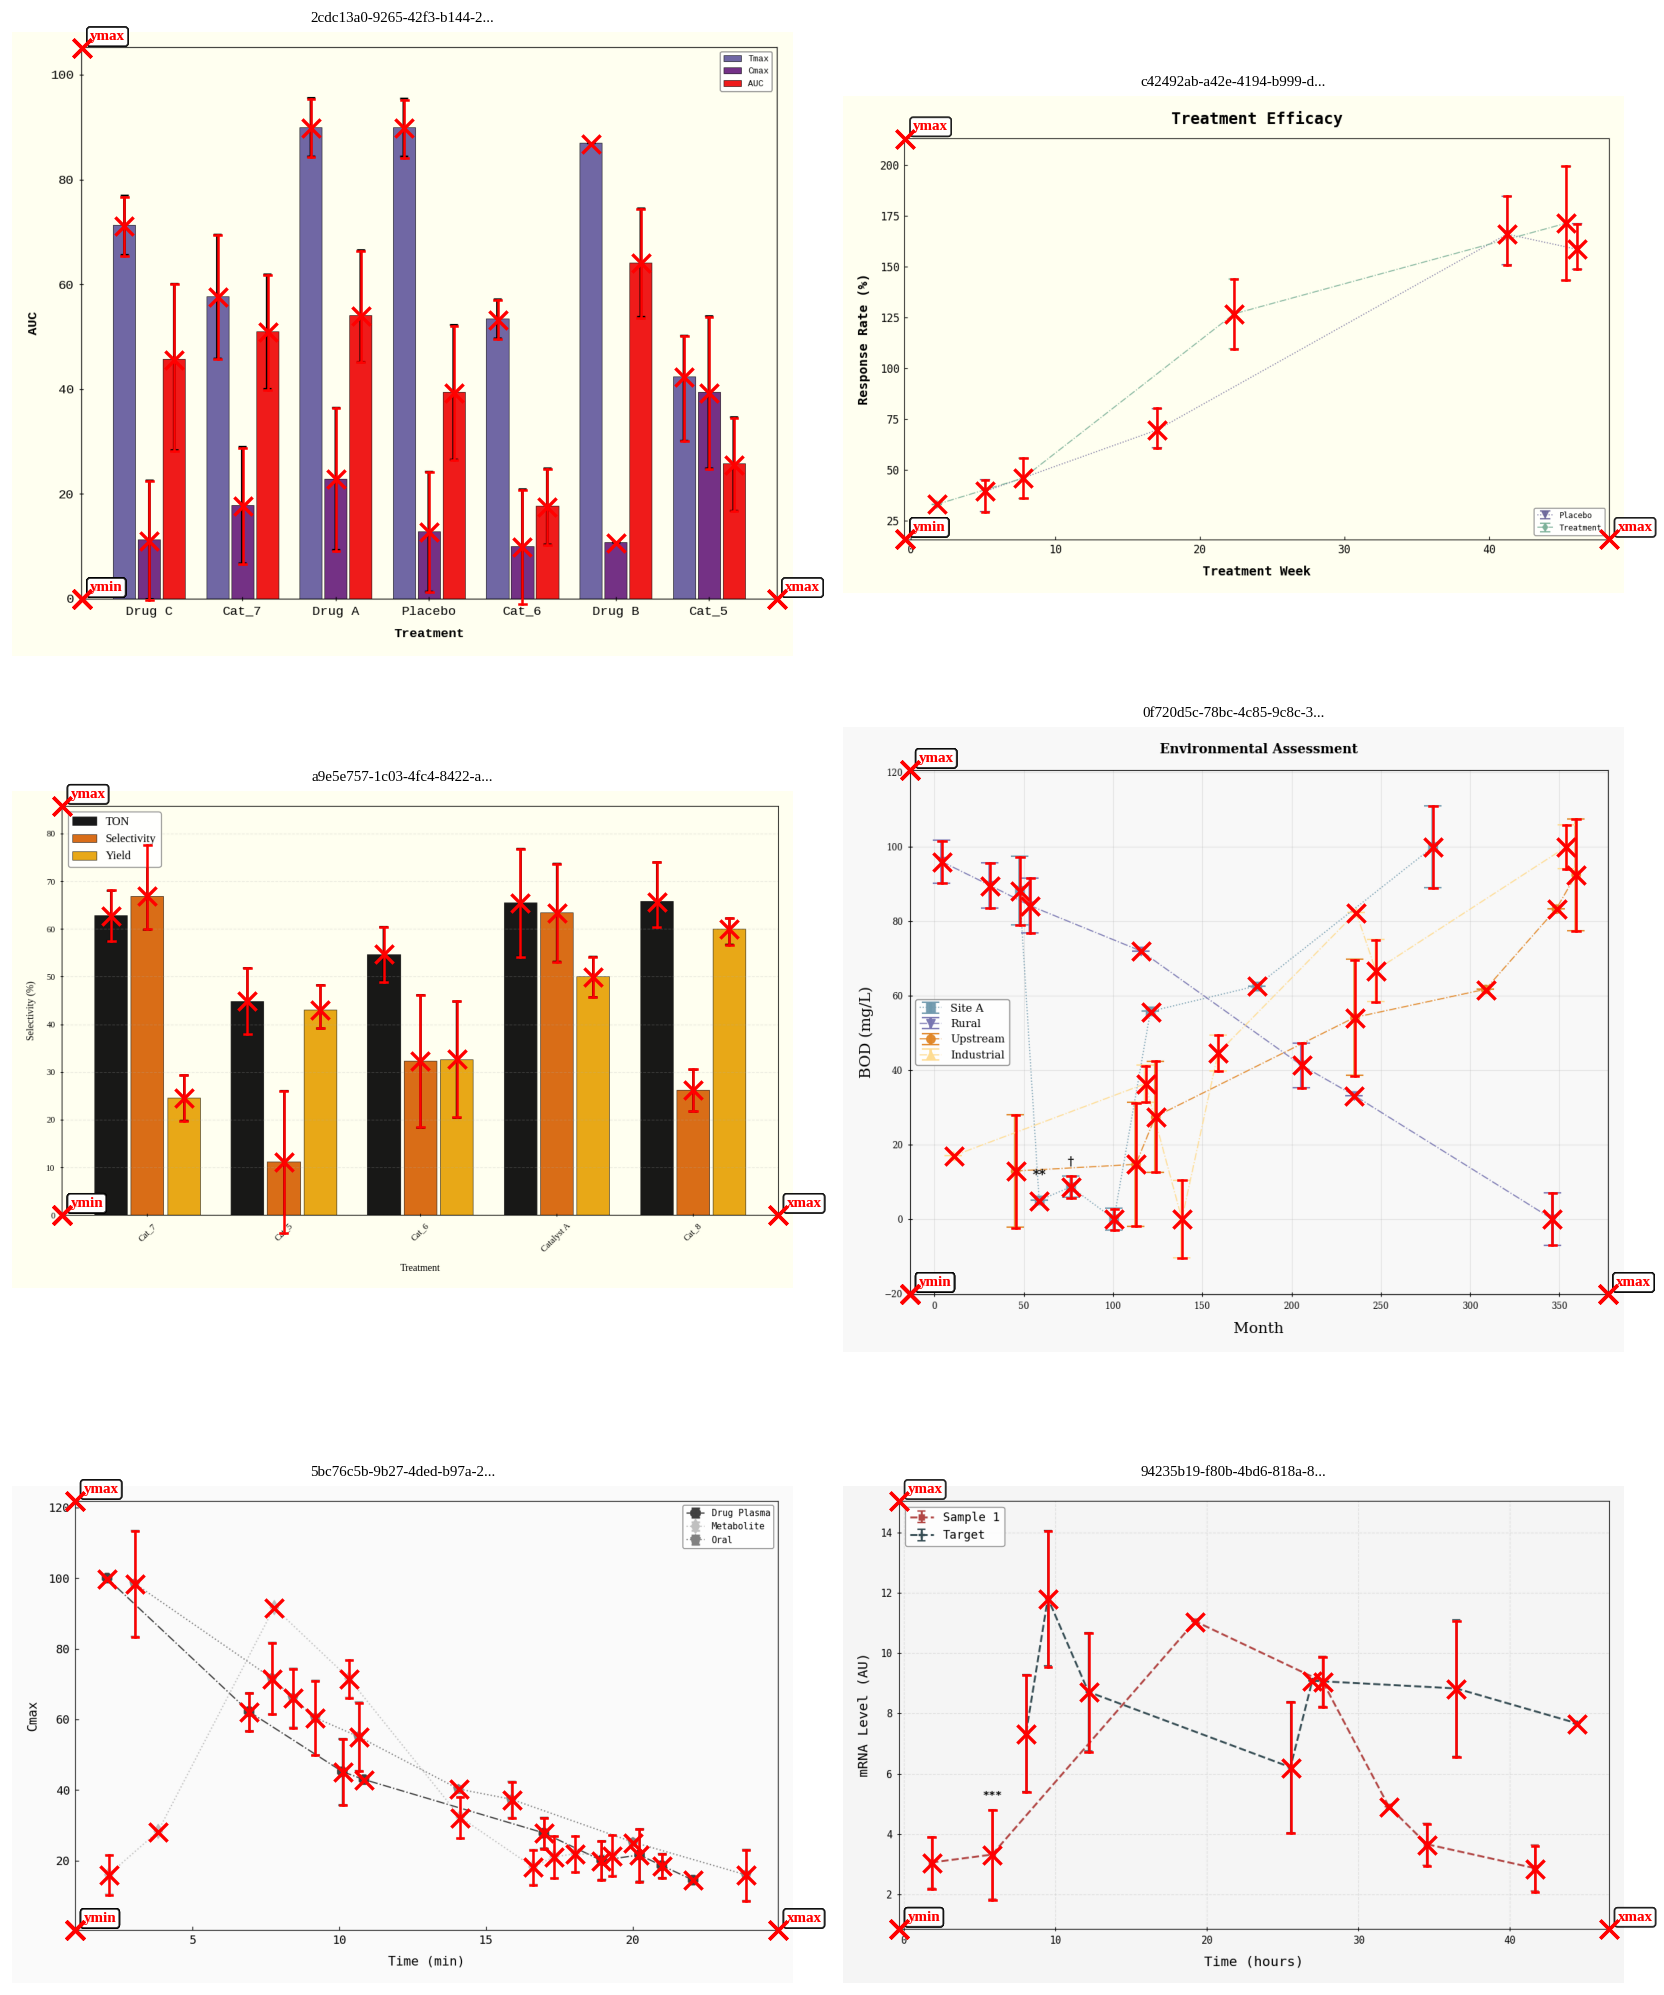


Verification completed


In [ ]:
# 15: Display Overlay Image to Verify JSON Labels

from IPython.display import Image as IPImage, display

# Generate overlay
visualize_with_overlay(
    images_dir=os.path.join(CONFIG["output_dir"], "images"),
    labels_dir=os.path.join(CONFIG["output_dir"], "labels"),
    num_samples=6
)

# Display
print("=" * 65)
print("Manual Coordinate Verification (Chart and JSON Matches or not)")
print("=" * 65)
print("Red X = JSON coordinates | Red lines = Error bars")
print("Labels: xmin, xmax, ymin, ymax = Boundary points")
print()
display(IPImage(filename="overlay_verification.png"))

print()
print("Verification completed")

In [ ]:
# 15: Create ZIP Archive

zip_filename = create_zip_archive(
    source_dir=CONFIG["output_dir"],
    output_filename="synthetic_error_bar_dataset.zip"
)

Creating ZIP archive: synthetic_error_bar_dataset.zip
Images: 3000
Labels: 3000
   Adding images...


   Zipping images:   0%|          | 0/3000 [00:00<?, ?it/s]

   Adding labels...


   Zipping labels:   0%|          | 0/3000 [00:00<?, ?it/s]


ZIP archive created successfully!
Filename: synthetic_error_bar_dataset.zip
Size: 160.62 MB


In [ ]:
# 16: Download Link

from IPython.display import FileLink, display

print()
print(f"Total images generated: {generation_stats['total_generated']}")
print(f"Output directory: {CONFIG['output_dir']}")
print(f"ZIP file: {zip_filename}")
print()
print("Download dataset:")
display(FileLink(zip_filename))


Total images generated: 3000
Output directory: synthetic_dataset
ZIP file: synthetic_error_bar_dataset.zip

Download dataset:


/kaggle/working/synthetic_error_bar_dataset.zip